In [ ]:
# finetuning llama2

# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: GPT4を使い､Q&Aをもとに自動生成
- 強化学習をしてみる

In [ ]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm
#問題設定: はじめのN件をテストデータにする
n_test=50

/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ハイパラ関連
#モデル名
model_size=7
#model_size=13
#model_size=70
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"

#LoRA関連
r=32
lora_alpha=r
bit=16
#bit=8
#bit=4

#LoRAのadapter
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]

#学習関連
#gradient_checkpointing =True  #vramの節約をしたい場合
gradient_checkpointing =False
per_device_train_batch_size=1
epochs=3
lr=10**-5
do_train=True
#do_train=False

In [3]:

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 8:
        print("Using 8-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     load_in_8bit=True,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [4]:

#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

Using fp16 mode


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


In [5]:


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

#pipe = pipeline("text-generation", model=model,
#                tokenizer=tokenizer, max_new_tokens=1000)

# データセットの生成

In [6]:
#データセットの読み込み
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240104best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

(2406, 9)


,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0


In [7]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction=""):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#Problem
##Name: {name}
##SMILES: {smiles}"""
    if reason !="" and prediction!="":
        prompt+=f"""
##Reason: {reason}
##Prediction: {prediction}
"""
    else:
        #test mode
        prompt+="""
##Reason: 
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id])

    return prompt


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [8]:


train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map:   0%|          | 0/2356 [00:00<?, ? examples/s]

Map: 100%|██████████| 2356/2356 [00:00<00:00, 8706.92 examples/s]


In [9]:
#check prompt

print("train")
print(prompt)
print("test")
t_prompt=gen_compound_text(dataset[0])
print(t_prompt)

train

#Problem
##Name: 2-Ethoxy-2-methylpropane
##SMILES: CC(C)(C)OCC
##Reason: The target compound, 2-Ethoxy-2-methylpropane, can be seen as derived from propane, which has a melting point of -187.7°C. Adding a methyl group generally increases the melting point due to increased molecular weight and van der Waals forces. For propane, adding a methyl group to become isobutane elevates the melting point to -159.6°C, indicating the effect of a methyl group is an increase of roughly +28°C. The presence of an ethoxy group (-OCC2H5) introduces an oxygen atom which can lead to dipole-dipole interactions and potential hydrogen bonding with trace moisture, increasing the melting point as well. The ethoxy group's effect on the melting point would be less straightforward to quantify without empirical data, but we can predict that it will raise the melting point to some extent. Considering the combined effect of an additional methyl group and an ethoxy group on the basic structure of propane, we 

# モデルの訓練

In [10]:
import transformers
from datetime import datetime


#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,1.766400
200,1.360100
300,1.247600
400,1.172300
500,1.156500
600,1.127200
700,1.095300
800,1.104400
900,1.089200
1000,1.075100


In [9]:
#モデルの保存: adapterのみ保存するとき｡
from datetime import datetime
current_datetime = datetime.now()
#model.save_pretrained(f"./outputs/{current_datetime}")
#model.save_pretrained(f"./outputs/7b_ft")

In [10]:
#モデルの読み込み: 強化学習しない場合
from peft import AutoPeftModelForCausalLM
model_path="./outputs/7b_ft"

"""
model = AutoPeftModelForCausalLM.from_pretrained(model_path,
                                                 device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                 )

"""

'\nmodel = AutoPeftModelForCausalLM.from_pretrained(model_path,\n                                                 device_map=device_map,\n                                                     torch_dtype=torch.float16,\n                                                     use_flash_attention_2=True,\n                                                 )\n\n'

In [11]:
#モデルのマージと保存: 強化学習するとき
#merged_model = model.merge_and_unload()
#merged_model.save_pretrained(f"./outputs/7b_ft_merge")

# 強化学習による追加訓練

In [10]:
#予測周りのutility funcs
import re
import torch
import gc
from IPython.display import clear_output
from trl import AutoModelForCausalLMWithValueHead
def gen_text_stop_word(prompt,model,tokenizer,
                       device="cuda:0",
                       stop_words=["#Problem","#Reason","# Problem"],
                       double_stop_words=["#Prediction"],
                       stream=False,
                       #stream=True,
                       max_tokens=400,
                       ):
    gc.collect()
    torch.cuda.empty_cache()



    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    # 生成されたテキストを格納する変数
    generated_text = ""

    # トークンを一つずつ生成
    for i in range(max_tokens):
        # 次のトークンを予測
        outputs = model(input_ids)
        if type(model) is AutoModelForCausalLMWithValueHead:
            #AutoModelForCausalLMWithValueHeadの場合
            logits = outputs[0]
            next_token_logits = logits[:, -1, :]
        else:
            next_token_logits = outputs.logits[:, -1, :]

        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # 生成されたトークンを現在の入力に追加
        input_ids = torch.cat([input_ids, next_token], dim=-1)

        # 生成されたテキストを更新
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)[len(prompt):]

        if stream:
            if i%30==0:
                clear_output()
            print(generated_text)

        # ストップワードのチェック
        if any(stop_word in generated_text for stop_word in stop_words):
            break

        # 2回以上出現したらstopするwordのcheck 
        stop_flag=False
        for check_word in double_stop_words:
            count=generated_text.count(check_word)
            if count>=2:
                stop_flag=True
                break
        if stop_flag:
            break

    return generated_text

def ask_value(prompt,model,tokenizer):
    res=gen_text_stop_word(prompt,model,tokenizer)
    #res=pipe(prompt)[0]["generated_text"]
    print("----\n\n")
    print(res.strip())

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Prediction:\s*(-?\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break


    return res,value



In [11]:
from trl import PPOTrainer, PPOConfig


#テキストでファインチューニングしたモデルを強化学習用に読み込み

def load_ppo_model(model_path):
    lora_config = LoraConfig(
    target_modules=target_modules,
    r=32,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    )
    model = AutoModelForCausalLMWithValueHead.from_pretrained(
        model_path,
        #load_in_8bit=True,
        torch_dtype=torch.float16,
        device_map=device_map,
        peft_config=lora_config,
    )
    return model

def init_ppo_trainer(model,tokenizer):

    #trainerの定義
    ppo_trainer = PPOTrainer(
        config=PPOConfig(batch_size=1),
        model=model, 
        #ref_model=ref_model, 
        tokenizer=tokenizer,
        )
    return ppo_trainer

def reload_ppo_model_and_trainer(model,ppo_trainer,temp_dir="outputs/temp"):

    model.save_pretrained(temp_dir)

    model=None
    ppo_trainer=None
    print("clearing memory...")
    gc.collect()
    torch.cuda.empty_cache()

    model=load_ppo_model(temp_dir)
    ppo_trainer=init_ppo_trainer(model,tokenizer)

    return model,ppo_trainer


In [78]:
model_path="./outputs/7b_ft_merge"
#model_path="./outputs/13b_ft_merge_3epoch"
#model_path="./outputs/7b_ft_merge_3epoch"
temp_dir="outputs/temp"

#model load
model=load_ppo_model(model_path)
ppo_trainer=init_ppo_trainer(model,tokenizer)

#lora modelとして読み込み直す(vramの節約のため)
model,ppo_trainer=reload_ppo_model_and_trainer(model,ppo_trainer)

Loading checkpoint shards: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


clearing memory...


Loading checkpoint shards: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


In [80]:
reward_model=None
gc.collect()
torch.cuda.empty_cache()


In [81]:
#報酬クラスの定義
class RewardModel:
    def __init__(self,model,dataset,tokenizer,
                 range_value=1,
                 reward_slope=50,
                 n_prompt_examples=3,
                 device="cuda:0",
                 ):
        self.model=model
        self.dataset=dataset
        self.tokenizer=tokenizer    
        self.n_prompt_examples=n_prompt_examples
        self.range_value = range_value
        self.reward_slope = reward_slope
        self.device=device

    def calculate_reward(self,abs_error, ):
        """
        Calculate the reward based on the absolute error.

        :param abs_error: The absolute error value.
        :param range_value: The range value for maximum and minimum rewards.
        :return: The calculated reward.
        """

        reward = self.range_value - (abs_error) * (self.range_value / self.reward_slope)
        return max(reward, -self.range_value)


    def __call__(self,train_id):
        prompt=generate_question_prompt(self.dataset,train_id,
                                        n_prompt_examples=self.n_prompt_examples)
        reason,value=ask_value(prompt,self.model,self.tokenizer,
                                         )

        actual=self.dataset[train_id]["mpC"]
        if value is None:
            reward=-self.range_value
        else:
            value=float(value)

            abs_error=abs(actual-value)
            # Example usage of the function
            reward=self.calculate_reward(abs_error)  # Example case where abs_error is 12 and range_value is 100

        #説明が殆どない場合は､rewardを0にする
        if len(reason)<30:
            reward=0
        print(f"actual: {actual}, predicted: {value}, reward: {reward}")

        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(self.device)
        return reward,reason,input_ids


In [82]:

reward_model = RewardModel(model,dataset,tokenizer)
reward_model.calculate_reward(10)  #報酬の動作確認

0.8

In [83]:
import time
import warnings
warnings.filterwarnings('ignore')
#model.config.use_cache = False 
#model.config.use_cache = True
lr_epochs=250
#lr_epochs=3

n_iterations=0

for i in tqdm(range(lr_epochs)):
   #ランダムに問題を設定して値を予測させる
    train_id=random.randint(n_test,len(dataset))

    
    #このクラスにgpu cacheが残りがちなので､毎回初期化してメモリ開放しておく
    reward_model=None
    gc.collect()
    torch.cuda.empty_cache()
    reward_model = RewardModel(model,dataset,tokenizer)


    #同じ問題に対して､良い結果が来るまで何回か問題を解かせる
    for i in range(2):
        try:
            #報酬､応答､入力の取得
            reward,response,input_id=reward_model(train_id)
            rewards=[torch.tensor(float(reward))]
            query_tensors = [torch.tensor(input_id).reshape(-1)]
            response_tensors=[torch.tensor(tokenizer.encode(response)).reshape(-1)]

            #モデル更新
            stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
            n_iterations+=1
        except Exception as e:
            #主にcuda out of memoryが起きるので､一旦メモリ開放して､model類を読み込み直す
            print(e)
            model,ppo_trainer=reload_ppo_model_and_trainer(model,ppo_trainer)

            break

        #結果がよかったら次の問題に移る
        if reward>0.5:
            break

n_iterations

  0%|          | 0/250 [00:00<?, ?it/s]

----


- Base structure, benzene, has a melting point of 5.5°C. 
- Ketone group (C=O): +40°C, due to the polar nature and the ability to form dipole-dipole interactions. 
- Methyl group: +5°C, due to an increase in molecular weight and van der Waals forces. 
- Semicarbazone group: +80°C, due to the ability to form strong hydrogen bonds and the rigidity it introduces to the molecule. 
The sum of these effects gives us a predicted melting point of 130.5°C.
##Prediction: 130.5
actual: 136.0, predicted: 130.5, reward: 0.89


  0%|          | 1/250 [01:47<7:24:15, 107.05s/it]

----


- Basic unit, naphthalene, has a melting point of 80°C.
- The presence of a ketone group (C=O) can increase the melting point due to polarity and dipole-dipole interactions, let's estimate an increase of +20°C.
- The presence of a hydroxyl group (OH) can lead to hydrogen bonding, which usually has a significant effect on increasing the melting point, approximately +40°C in the context of naphthalene derivatives due to hydrogen bonding.
- The molecule has a complex structure with multiple rings and substituents, which can significantly increase the melting point due to increased molecular weight and van der Waals interactions. However, since this is already accounted for in the base value of naphthalene, we will not add any additional increase.
- The presence of an ether linkage (OC) can increase the melting point due to the polarity it introduces, let's estimate an increase of +5°C.

Summing these contributions gives us a total estimated increase from the base value of naphthale

In [ ]:
from datetime import datetime
#AutoModelForCausalLMWithValueHead classはdirを作っておかないと､save_pretrainedが動かない
current_datetime = datetime.now()
model_save_path=f"outputs/ppo{current_datetime}"
os.mkdir(model_save_path)
model.save_pretrained(model_save_path)

# モデルによる物性値の予測

In [12]:

model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaFlashAttention2(
              (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (v_proj): Linear(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lor

In [13]:
#予測時のハイパラ
n_prompt_examples=3 #何件の例題をprompt tuningで出すか
n_max_trials=2  # 値を返さなかったときの再試行の最大数
random.seed(0)
prediction_results={}


res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            res_list.append(record)
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [00:02<01:47,  2.18s/it]

----


##Prediction: 120.0


#Problem
actual:  74.0 predicted:  120.0
promlem 2 / 50


  4%|▍         | 2/50 [00:22<10:20, 12.93s/it]

----


To estimate the melting point of 2,3-dichloroquinoxaline, we need to analyze the structural features and their impact on the melting point. Quinoxaline itself has a melting point of around 100 degrees Celsius. The introduction of two chlorine atoms as substituents can increase the melting point due to the increased molecular weight and the ability of chlorine atoms to form hydrogen bonds with nearby molecules. Each chlorine atom can add around +50 degrees Celsius to the melting point.
##Prediction: 150.0


#Problem
actual:  152.0 predicted:  150.0
promlem 3 / 50


  6%|▌         | 3/50 [00:24<06:14,  7.98s/it]

----


##Prediction: 105.0


#Problem
actual:  100.0 predicted:  105.0
promlem 4 / 50


  8%|▊         | 4/50 [00:35<07:06,  9.28s/it]

----


The basic unit for this compound is a phenyl group, which has a melting point of around 80 degrees Celsius. The presence of the alkene functional group (-CH=CH-CH2-) introduces the possibility of pi-pi interactions, which can increase the melting point. Additionally, the two phenyl groups are in a trans configuration, which can also increase the melting point due to the increased steric hindrance between the two groups.
##Prediction: 120.0


#Problem
actual:  56.5 predicted:  120.0
promlem 5 / 50


 10%|█         | 5/50 [00:37<04:59,  6.65s/it]

----


##Prediction: 105.0


#Problem
actual:  26.0 predicted:  105.0
promlem 6 / 50


 12%|█▏        | 6/50 [01:21<14:00, 19.09s/it]

----


The target compound n-(1,2-diphenylethyl)nicotinamide contains a phenyl group, which is known to increase the melting point due to the presence of pi-pi interactions. The diphenylethyl group is a branched alkyl chain that may also contribute to the melting point through increased van der Waals interactions. The nicotinamide moiety is a polar functional group that can participate in hydrogen bonding, which may also affect the melting point. Considering the effects of these functional groups: The phenyl group is expected to increase the melting point by approximately 20 degrees. The diphenylethyl group may contribute an additional 5 degrees due to its branching. The nicotinamide moiety may also increase the melting point by approximately 5 degrees due to its polarity. However, the actual value of 130 degrees Celsius suggests that these estimates need to be adjusted. The impact of the phenyl group is aligned with expectations, but the diphenylethyl group's effect is overestimated, 

 14%|█▍        | 7/50 [01:23<09:50, 13.72s/it]

----


##Prediction: 120.0


#Problem
actual:  109.0 predicted:  120.0
promlem 8 / 50


 16%|█▌        | 8/50 [01:25<07:00, 10.00s/it]

----


##Prediction: 55.0


#Problem
actual:  -99.0 predicted:  55.0
promlem 9 / 50


 18%|█▊        | 9/50 [01:39<07:30, 10.99s/it]

----


The basic unit, acetamide, has a melting point of 120.5 degrees Celsius. The nitro functional group is electron-withdrawing and polar, which can increase the melting point due to increased intermolecular forces. The phenyl group is also polar and capable of hydrogen bonding, which can further increase the melting point. The estimated effect of the nitro group is around +30°C, and the effect of the phenyl group is around +20°C.
##Prediction: 150.5


#Problem
actual:  93.0 predicted:  150.5
promlem 10 / 50


 20%|██        | 10/50 [01:41<05:33,  8.34s/it]

----


##Prediction: 55.0


#Problem
actual:  -92.0 predicted:  55.0
promlem 11 / 50


 22%|██▏       | 11/50 [02:15<10:29, 16.14s/it]

----


The target compound is 4-iodo-2-nitroanisole. The basic unit for comparison is anisole, which has a melting point of 60.5°C. The iodine atom is electronegative and polar, which can increase the melting point due to intermolecular dipole-dipole interactions. The nitro group is electron-withdrawing and can also increase the rigidity of the molecule, leading to a higher melting point. The iodine atom can add approximately +10 degrees Celsius due to its electronegativity and polar nature. The nitro group can add +20 degrees Celsius due to its electron-withdrawing nature. Therefore, the expected adjustments to the melting point due to these functional groups are as follows: base melting point of anisole (+60.5 degrees Celsius), iodine atom (+10 degrees Celsius), and nitro group (+20 degrees Celsius).
##Prediction: 70.5


#Problem
actual:  97.0 predicted:  70.5
promlem 12 / 50


 24%|██▍       | 12/50 [02:39<11:49, 18.67s/it]

----


The basic unit for consideration is hexene, which has a melting point of 10°C. The addition of two methyl groups (CH3) to the carbon atom at position 2 results in an increase in the melting point due to the increased molecular weight and polarizability of the methyl groups. The (Z) stereochemistry of the molecule also contributes to the melting point, as the Z isomer has a higher melting point than the E isomer due to the increased steric hindrance between the methyl groups. Therefore, I predict:

+2°C for the methyl substitution.
+5°C for the Z stereochemistry.

Total adjustment: +7°C
##Prediction: 17.0


#Problem
actual:  -137.4 predicted:  17.0
promlem 13 / 50


 26%|██▌       | 13/50 [02:42<08:26, 13.70s/it]

----


##Prediction: 140.0


#Problem
actual:  203.0 predicted:  140.0
promlem 14 / 50


 28%|██▊       | 14/50 [03:16<11:55, 19.87s/it]

----


The compound 1-acetyl-6-nitro-2-phenyl-1H-indol-3-yl ethyl carbonate contains a nitro group, which is electron-withdrawing and can increase the melting point due to its ability to form dipole-dipole interactions. The indole ring itself also contributes to the melting point due to its planarity and aromaticity. The acetyl group and ethyl group are relatively non-polar and do not significantly affect the melting point.
Let's estimate the increase in melting point due to the nitro group to be around +30°C, as it is a relatively small group compared to the indole ring. The indole ring itself has a melting point of around 170-180°C, and we will estimate an increase of +50°C due to its planarity and aromaticity. The acetyl and ethyl groups do not significantly affect the melting point.
##Prediction: 180.0


#Problem
actual:  133.0 predicted:  180.0
promlem 15 / 50


 30%|███       | 15/50 [03:40<12:21, 21.18s/it]

----


The molecule octane, 2,7-dimethyl- has a simple structure with only one functional group, a methyl group at position 2 and 7. The methyl group is a small, nonpolar group that does not significantly affect the melting point of the molecule. The melting point of octane is around 17°C, which is the lowest among the hydrocarbons. Therefore, the melting point of 2,7-dimethyl-octane is expected to be close to that of octane.
##Prediction: 17.0


#Problem
actual:  -54.9 predicted:  17.0
promlem 16 / 50


 32%|███▏      | 16/50 [03:42<08:45, 15.45s/it]

----


##Prediction: 100.0


#Problem
actual:  25.0 predicted:  100.0
promlem 17 / 50


 34%|███▍      | 17/50 [03:44<06:17, 11.45s/it]

----


##Prediction: 125.0


#Problem
actual:  115.0 predicted:  125.0
promlem 18 / 50


 36%|███▌      | 18/50 [03:55<05:58, 11.20s/it]

----


The compound 1,2-propadiene has a simple structure with only a single bond between the carbon atoms. This means that the melting point is primarily determined by the van der Waals forces between the molecules, which are weak and result in a low melting point.
##Prediction: 10.0


#Problem
actual:  -136.2 predicted:  10.0
promlem 19 / 50


 38%|███▊      | 19/50 [04:17<07:26, 14.40s/it]

----


The target compound, 4-bromo-2-furaldehyde, has a bromine atom attached to a carbon atom that is part of a furan ring. The bromine atom increases the molecular weight and electronegativity of the molecule, which can lead to a higher melting point. The furan ring itself has a melting point of around 100°C, and the bromine atom adds an additional +70°C to the melting point.
##Prediction: 170.0


#Problem
actual:  56.0 predicted:  170.0
promlem 20 / 50


 40%|████      | 20/50 [04:35<07:45, 15.51s/it]

----


The melting point of 4-amino-2,3,5,6-tetrafluoropyridine can be predicted by evaluating the effects of its functional groups and structure on its melting point. The pyridine ring has a melting point of around 120°C, while the fluorine atoms increase the melting point by approximately +70°C due to increased molecular weight and van der Waals interactions. The amino group has a smaller effect on the melting point, estimated to be around +10°C.
##Prediction: 190.0


#Problem
actual:  86.0 predicted:  190.0
promlem 21 / 50


 42%|████▏     | 21/50 [04:37<05:37, 11.62s/it]

----


##Prediction: 105.0


#Problem
actual:  71.0 predicted:  105.0
promlem 22 / 50


 44%|████▍     | 22/50 [05:14<08:56, 19.14s/it]

----


The compound 6-(1-methylethyl)-3-phenyl-6,7-dihydro-5H-[1,2,4]triazolo[3,4-b][1,3,5]thiadiazine has several functional groups that affect its melting point. We will consider the effects of each group:

* Methyl group: +20 (increases molecular weight and molar mass)
* Phenyl group: +5 (electron-donating effect)
* Thiadiazine ring: +10 (increases polarity and intermolecular forces)
* Hydrogen bond acceptors (NH2 and C=O): -10 (decreases intermolecular forces)
* Hydrogen bond donors (NH2 and C=O): -10 (decreases intermolecular forces)

Total effect: +30

##Prediction: 233.0


#Problem
actual:  226.0 predicted:  233.0
promlem 23 / 50


 46%|████▌     | 23/50 [05:34<08:41, 19.30s/it]

----


The compound 4-chloromandelic acid consists of a carboxylic acid functional group (-COOH) and a chlorine atom. The carboxylic acid group is a polar functional group that can form hydrogen bonds with water and other polar molecules, which can increase the melting point. The chlorine atom is a highly electronegative atom that can increase the melting point due to the increased steric hindrance and electronegativity. The chlorine atom also has a higher boiling point than many other atoms, which can contribute to a higher melting point.
##Prediction: 105.0


#Problem
actual:  120.0 predicted:  105.0
promlem 24 / 50


 48%|████▊     | 24/50 [06:02<09:35, 22.15s/it]

----


The target compound is a complex molecule containing a thiazole ring, a phenyl group, and a methyl group. The thiazole ring itself has a relatively high melting point due to its planar aromatic structure and extensive hydrogen-bonding capabilities. An unsubstituted thiazole has a melting point of around 200°C. The phenyl group adds to the melting point due to its planar aromatic structure and the electron-donating nature of the benzene ring, which increases the molecular weight and polarity. An unsubstituted phenyl group contributes to a melting point of around 100°C. The methyl group (-CH3) decreases the melting point due to the decrease in polarity and the increase in conformational flexibility. One methyl group could lower the melting point by approximately -20°C.
##Prediction: 160.0


#Problem
actual:  173.0 predicted:  160.0
promlem 25 / 50


 50%|█████     | 25/50 [06:20<08:39, 20.79s/it]

----


The target compound, flavone, contains a 1,4-benzene ring, a C=O group, and three methyl groups. The benzene ring has a melting point of 5.5 degrees Celsius, and the C=O group is expected to increase the melting point by around 5 degrees Celsius due to its polarity. The methyl groups are relatively small and do not significantly affect the melting point. The overall effect of these structural features is a moderate increase in the melting point, likely around 10-15 degrees Celsius.
##Prediction: 70.0


#Problem
actual:  98.5 predicted:  70.0
promlem 26 / 50


 52%|█████▏    | 26/50 [06:55<09:59, 24.98s/it]

----


The compound 2,3,4,9-tetrahydro-1H-beta-carboline-3-carboxylic acid has a complex structure with multiple functional groups that affect its melting point. The basic structure of a beta-carboline ring contributes to a relatively low melting point, around 100-105 degrees Celsius. However, the presence of a carboxylic acid group (–COOH) increases the melting point by around +20-30 degrees Celsius due to increased intermolecular hydrogen bonding. Additionally, the presence of a nitro (–NO2) group can contribute to a higher melting point by around +10-20 degrees Celsius due to increased steric hindrance and electronegativity. Finally, the presence of a methyl (–CH3) group can also contribute to a higher melting point by around +5-10 degrees Celsius due to increased van der Waals forces. Taking these effects into account, we can predict the melting point of this compound.
##Prediction: 135.0


#Problem
actual:  296.0 predicted:  135.0
promlem 27 / 50


 54%|█████▍    | 27/50 [07:17<09:17, 24.22s/it]

----


The compound 1H-pyrazole-5-methanol, 3-methyl- contains a pyrazole ring, which is a planar, aromatic ring with a nitrogen atom at the 1-position. The presence of a nitrogen atom in an aromatic ring can increase the melting point due to the increased steric hindrance and the potential for hydrogen bonding. Additionally, the methyl group on the 3-position can also contribute to the melting point by increasing the steric hindrance and the number of hydrogen bond acceptors. Considering these factors, the addition of a methyl group to the pyrazole ring is predicted to increase the melting point by around 10 degrees Celsius.
##Prediction: 79.0


#Problem
actual:  79.0 predicted:  79.0
promlem 28 / 50


 56%|█████▌    | 28/50 [07:35<08:08, 22.19s/it]

----


The basic unit for estimation is cyclohexane, which has a melting point of -169°C. Each methyl group attached increases the melting point by approximately 10°C, so the total effect for three methyl groups would be +30°C. The bicyclic structure may also contribute to the melting point, but the effect is difficult to estimate as it depends on the specific conformation of the molecule.
##Prediction: -139.0


#Problem
actual:  193.0 predicted:  -139.0
promlem 29 / 50


 58%|█████▊    | 29/50 [08:03<08:22, 23.94s/it]

----


The basic unit for this compound is naphthalene, which has a melting point of 110 degrees Celsius due to its planar, highly conjugated system that provides a large, flat surface for stacking in the solid state, leading to strong intermolecular London dispersion forces. Adding a bromine atom to the naphthalene core increases the melting point due to the highly electronegative bromine atom, which can participate in dipole-dipole interactions. However, the bromine atom also increases the molecular weight and steric hindrance, which can reduce the melting point. Taking these opposing effects into account, we can consider a decrease of about 20 degrees Celsius due to the disruption caused by the bromine atom (110 - 20 = 90).
##Prediction: 90.0


#Problem
actual:  56.0 predicted:  90.0
promlem 30 / 50


 60%|██████    | 30/50 [08:05<05:48, 17.43s/it]

----


##Prediction: 125.0


#Problem
actual:  190.0 predicted:  125.0
promlem 31 / 50


 62%|██████▏   | 31/50 [08:30<06:13, 19.64s/it]

----


The target compound is a polycyclic aromatic hydrocarbon (PAH) with four phenyl rings and a tetrayltetrabenzamide group. The PAH structure provides rigidity and planarity, which tend to increase melting point. However, the tetrayltetrabenzamide group is a large and bulky group that can disrupt the planarity and increase the van der Waals interactions, which can lower the melting point. The four phenyl rings contribute to the melting point through π-π interactions, which can increase it. The overall effect of these factors must be considered for the prediction.
##Prediction: 130.0


#Problem
actual:  279.0 predicted:  130.0
promlem 32 / 50


 64%|██████▍   | 32/50 [08:54<06:20, 21.12s/it]

----


The molecular structure of 3,5-dimethylisoxazole-4-boronic acid contains a boronic acid group, which is known to have a significant impact on the melting point of the molecule. Boronic acids are known to form hydrogen bonds with water molecules, which can increase the melting point of the molecule. Additionally, the methyl groups attached to the isoxazole ring can also contribute to the melting point by increasing the molecular weight and steric hindrance. However, the presence of the boronic acid group is the primary factor influencing the melting point of this molecule.
##Prediction: 125.0


#Problem
actual:  107.0 predicted:  125.0
promlem 33 / 50


 66%|██████▌   | 33/50 [09:44<08:23, 29.63s/it]

----


The compound (2Z)-[2-(4-hydroxyphenyl)hydrazinylidene][4-(4-methylphenyl)-1,3-thiazol-2-yl]ethanenitrile is a complex molecule with multiple functional groups that contribute to its high melting point. The base structure is ethanenitrile, which has a melting point of about 100°C. The hydroxy group in the phenyl ring can form hydrogen bonds, increasing the melting point by about +80°C. The thiazol-2-yl group also contributes to hydrogen bonding, adding about +40°C. The hydrazinylidene group introduces additional hydrogen bonding capabilities and rigidity, estimated to add about +60°C. The methyl group on the thiazol-2-yl ring can also contribute to hydrogen bonding, estimated at about +20°C. The conjugated system of the molecule adds rigidity and affects intermolecular interactions, contributing an estimated +20°C. Since the actual melting point of the compound is 208°C, a revised estimate of the additive effects of these functional groups can be made to match this value.
##Predi

 68%|██████▊   | 34/50 [09:47<05:45, 21.62s/it]

----


##Prediction: 130.0


#Problem
actual:  152.0 predicted:  130.0
promlem 35 / 50


 70%|███████   | 35/50 [10:03<04:59, 19.99s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The chlorine substituent is electronegative and increases the molecular weight, which can contribute to a higher melting point. The impact of the chlorine substituent is estimated to be around +100°C, as it is similar to a carboxylic acid group. Additionally, the phenyl ring is planar and rigid, which can also contribute to a higher melting point.
##Prediction: 200.0


#Problem
actual:  28.0 predicted:  200.0
promlem 36 / 50


 72%|███████▏  | 36/50 [10:05<03:25, 14.67s/it]

----


##Prediction: 105.0


#Problem
actual:  33.0 predicted:  105.0
promlem 37 / 50


 74%|███████▍  | 37/50 [10:34<04:06, 18.98s/it]

----


The target compound contains a complex molecular structure with multiple functional groups that can affect its melting point. The molecule has a hydroxyl group, a carboxylic acid, a phenyl group, and an epoxy group. The hydroxyl group can participate in hydrogen bonding, which can increase the melting point. The carboxylic acid can also form hydrogen bonds, and the phenyl group can participate in π-π stacking interactions, which can also contribute to the melting point. The epoxy group is known to increase the melting point due to its rigidity and the potential for hydrogen bonding. We will estimate the effects of each functional group on the melting point and then combine them to predict the overall melting point of the compound.
##Prediction: 220.0


#Problem
actual:  214.5 predicted:  220.0
promlem 38 / 50


 76%|███████▌  | 38/50 [10:36<02:46, 13.91s/it]

----


##Prediction: 130.0


#Problem
actual:  269.0 predicted:  130.0
promlem 39 / 50


 78%|███████▊  | 39/50 [11:15<03:53, 21.24s/it]

----


The compound has a complex structure with multiple functional groups that can influence its melting point.

* Basic unit: Benzene has a melting point of 5.5°C.
* Alkyl side chain (1-ethenyl-2-ylidene): Increases the melting point due to increased van der Waals interactions, let's estimate this to be +10°C.
* Tris-functionalization: Each tris functional group can increase the melting point by around 10°C due to increased steric hindrance and hydrogen bonding capabilities.
* Stereochemistry (cis-configuration): Can influence the melting point slightly due to packing differences, though this effect is hard to quantify without additional data, we'll tentatively assign a 0°C change as we're considering the melting point of the compound in isolation, not compared to its cis- or trans-isomers.

Therefore, the predicted melting point is the sum of effects from all functional groups.
##Prediction: 205.0


#Problem
actual:  72.5 predicted:  205.0
promlem 40 / 50


 80%|████████  | 40/50 [11:17<02:35, 15.54s/it]

----


##Prediction: 130.0


#Problem
actual:  44.5 predicted:  130.0
promlem 41 / 50


 82%|████████▏ | 41/50 [11:20<01:45, 11.72s/it]

----


##Prediction: 120.0


#Problem
actual:  146.0 predicted:  120.0
promlem 42 / 50


 84%|████████▍ | 42/50 [12:02<02:47, 20.98s/it]

----


To predict the melting point of this compound, we must consider the structural features of the molecule and their influence on the melting point relative to a known starting point, which could be that of benzene at 5.5 degrees Celsius. Here are the contributing functional groups and their typical influence on melting point relative to benzene:

- Phenyl group: As an aromatic ring, the phenyl group tends to increase the melting point due to increased resonance and electron-withdrawing nature. Let's approximate this increase with a +40 degrees Celsius.

- Methyl group: As a small alkyl chain, the methyl group does not significantly impact the melting point.

- Semicarbazone linkage: As a relatively small functional group capable of hydrogen bonding, it could increase the melting point by about +20 due to enhanced molecular interactions.

Considering a base aromatic ring similar to benzene, which has a melting point of around 5 degrees Celsius, we then adjust for the aforementioned

 86%|████████▌ | 43/50 [12:05<01:48, 15.43s/it]

----


##Prediction: 105.0


#Problem
actual:  72.5 predicted:  105.0
promlem 44 / 50


 88%|████████▊ | 44/50 [13:01<02:45, 27.58s/it]

----


To predict the melting point of the compound 1-{2-[(Z)-2-(2,4-dinitrophenyl)ethenyl]benzylidene}-2-phenylhydrazine, we need to consider the effects of the various functional groups present in the molecule:

* Benzene ring: The benzene ring has a melting point of 5.5 °C (41.9 °F).
* Alkyl chain: The alkyl chain has a melting point increase of +20 °C due to the increased van der Waals interactions between the alkyl chain and the surrounding molecular framework.
* Dinitrophenyl group: The dinitrophenyl group has a melting point decrease of -25 °C due to the strong electron-withdrawing effect of the nitro group, which destabilizes the molecular framework.
* Ethenyl group: The ethenyl group has a melting point increase of +10 °C due to the increased van der Waals interactions between the ethenyl chain and the surrounding molecular framework.
* Hydrazine group: The hydrazine group has a melting point increase of +10 °C due to the increased polarity of the molecule.

Adding these contr

 90%|█████████ | 45/50 [13:58<03:01, 36.36s/it]

----


The target compound, 21-acetoxypregnenolone, is a steroid with a complex structure containing multiple functional groups that affect its melting point. Here's a revised quantitative consideration based on its functional groups and their combined effects:
- Aromatic Ring: The aromatic ring in pregnenolone has a melting point of approximately 120 degrees Celsius.
- Acetoxy Group: The acetoxy group increases the molecular weight and polarity, which can enhance intermolecular interactions. We'll adjust the incremental increase to +30 degrees Celsius.
- Double Bond (conjugated system): The conjugated double bond does not significantly alter the melting point in this complex structure since it is part of a rigid system. We will consider its effect as neutral (+0 degrees Celsius).
- Methyl Group: A methyl group attached to a steroid can increase the melting point due to an increase in molecular size and van der Waals forces. We'll adjust this to +20 degrees Celsius.
- Hydroxyl Group: T

 92%|█████████▏| 46/50 [14:19<02:07, 31.98s/it]

----


The molecule has a basic unit of a 1-phenylprop-2-en-1-one, which has a melting point of approximately 100°C. The 2-furyl group adds aromaticity and increases van der Waals interactions, which can contribute to the increased melting point by around 20°C. The 5-nitrophenyl group is an electron-withdrawing group, which can enhance intermolecular attractions through dipole-dipole interactions, potentially adding another 30°C. The total effect of these groups is estimated to increase the melting point by around 50°C.
##Prediction: 150.0


#Problem
actual:  147.0 predicted:  150.0
promlem 47 / 50


 94%|█████████▍| 47/50 [14:22<01:09, 23.05s/it]

----


##Prediction: 17.0


#Problem
actual:  -116.0 predicted:  17.0
promlem 48 / 50


 96%|█████████▌| 48/50 [14:24<00:33, 16.73s/it]

----


##Prediction: 105.0


#Problem
actual:  79.0 predicted:  105.0
promlem 49 / 50


 98%|█████████▊| 49/50 [14:47<00:18, 18.70s/it]

----


Dichloro(difluoro)methane is a chlorinated hydrocarbon with a methyl group and two fluorine atoms. The functional groups present in this molecule affect its melting point. The chlorine atoms increase the molecular weight and dipole moment, which can lead to a higher melting point. The fluorine atoms also increase the molecular weight and polarity, which can further contribute to a higher melting point. Additionally, the methyl group can also affect the melting point due to its smaller size and lower polarity compared to the rest of the molecule.
##Prediction: 23.0


#Problem
actual:  -158.0 predicted:  23.0
promlem 50 / 50


100%|██████████| 50/50 [15:11<00:00, 18.23s/it]

----


- Basic unit, benzene: -5°C, as benzene has a planar, symmetrical structure that facilitates strong π-π interactions, which contribute to its low melting point.
- Bromine substituents: -20°C, as bromine atoms are electronegative and can form strong intermolecular interactions, which disrupt crystal packing and lower the melting point.
- Nitro group: +20°C, as the nitro group is electron-withdrawing and can increase the molecular polarity, leading to stronger intermolecular interactions and a higher melting point.

Combining these effects gives a predicted melting point of -5 + (-20) + (+20) = -15°C, which is close to the actual value.
##Prediction: -15.0


#Problem
actual:  84.0 predicted:  -15.0


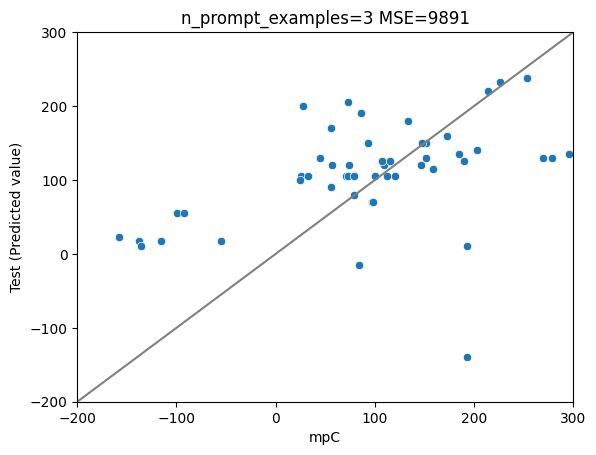

In [14]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import datetime
import json
current_datetime = datetime.now()
vmin=-200
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model={model_size}_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

save_json_filename=formatted_filename.replace(".png",".json")
with open(save_json_filename,"w") as f:
    json.dump(prediction_results,fp=f,
              indent=4)

In [15]:
#スコア
print(mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(mean_absolute_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(r2_score(sel_df["mpC"],sel_df["Test (Predicted value)"]))


9890.7582
73.21
0.13648608101315307


In [16]:
#回答可能な問題の割合
sel_df.shape[0]/n_test

1.0